In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.set_printoptions(precision=6, linewidth=110)

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0, '../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import uncertaintysampling as us

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(us)

import constants
imp.reload(constants)
from constants import *

In [3]:
def plot_2d_func(axes, func, xlow, xhigh, nx, ylow, yhigh, ny, 
                 interpolation='bicubic', colorbar=True, colorbar_label='z'):
    """Generate a heatmap from the function func.
    """
    # Generate 2d array of z-values
    xs = np.linspace(xlow, xhigh, nx)
    ys = np.linspace(ylow, yhigh, ny)
    zgrid = np.array([[func(x, y) for y in ys] for x in xs])
    
    # Make the plot
    extent = [xs[0], xs[-1], ys[0], ys[-1]]
    im = axes.imshow(zgrid.T, interpolation=interpolation, origin='lower', 
                 extent=extent, aspect='auto')
    
    # Make the colorbar
    if colorbar:
        cb = plt.colorbar(mappable=im, ax=axes)
        cb.set_label(label=colorbar_label)
        
        
def plot_numbered_points(axes, points):
    """
    """
    for i in range(len(points)-1):
        axes.scatter(points[i, 0], points[i, 1], marker='$'+str(i)+'$', s=100, color='r')
        
    axes.scatter(points[-1, 0], points[-1, 1], marker='$'+str(len(points)-1)+'$', s=150, color='orange')

# Load surrogate model

In [4]:
Bamp_filename = '../data/flowp00015/Bamp_lhd.hdf5'
Bphase_filename = '../data/flowp00015/Bphase_lhd.hdf5'
damp_gp_filename = '../data/flowp00015/amp_gp_lhd.hdf5'
dphase_gp_filename = '../data/flowp00015/phase_gp_lhd.hdf5'
sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, damp_gp_filename, dphase_gp_filename)

# Add new points with uncertainty sampling

In [14]:
original_points = sur.dphase_gp_list[0].X_train_
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
kernel_type = 'matern52'
dphase_gp_list = sur.dphase_gp_list

sampler = us.UncertaintySampling(original_points, limits, kernel_type, dphase_gp_list)

In [79]:
# (200, 30) is fairly reliable but slow (overnight for 150 points)
# sampler.add_new_points(1, nbasinjumps=200, nfun_eval_per_basin=30, verbose=True)

#sampler.add_new_points(30, nbasinjumps=100, nfun_eval_per_basin=20, verbose=True)

sampler.add_new_points(50, nbasinjumps=50, nfun_eval_per_basin=15, verbose=True)

err_new=0.634695832455, neval=2970, evaluation time=109.458788872
point_new=[  8.290098e-01  -7.000000e-01   7.000000e-01   1.000000e+04   1.000000e+04]
err_new=0.684520104761, neval=3912, evaluation time=4235.24879599
point_new=[  6.661469e-01   7.000000e-01  -7.000000e-01   1.000000e+04   0.000000e+00]
err_new=0.640276589864, neval=3408, evaluation time=117.415611029
point_new=[  6.517155e-01  -3.411632e-01  -7.000000e-01   1.000000e+04   4.983319e+03]
err_new=0.645974714003, neval=3378, evaluation time=119.822344065
point_new=[  7.374332e-01   7.000000e-01   7.000000e-01   0.000000e+00   5.890201e+03]
err_new=0.656461926185, neval=4032, evaluation time=140.296118975
point_new=[  1.000000e+00  -6.999999e-01   4.446452e-02   9.999999e+03   9.999999e+03]
err_new=0.643611755157, neval=3492, evaluation time=124.513136148
point_new=[  4.541020e-01   4.157057e-01  -7.000000e-01   4.006999e+03   1.000000e+04]
err_new=0.617384267576, neval=4056, evaluation time=144.873749018
point_new=[  8.5

In [83]:
points_errors = np.concatenate((sampler.new_points.T, np.array([sampler.new_errors]))).T
print len(points_errors)

#np.savetxt('../data/flowp00015/uncertainty_sampling_from_lhd_trainset.txt', points_errors)

200


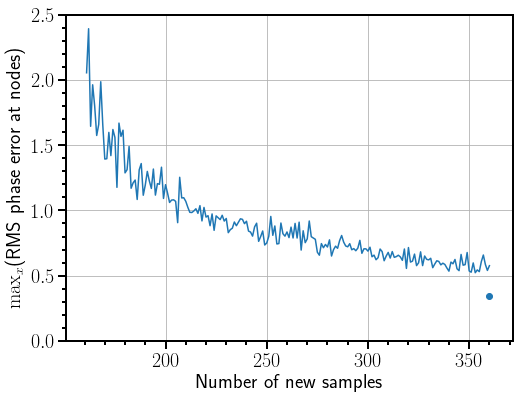

In [95]:
fig, axes = plt.subplots(1, figsize=(8, 6))
axes.plot(range(161, len(sampler.new_errors)+161), sampler.new_errors)
axes.scatter(360, 0.343, label='')
axes.set_xlabel('Number of new samples')
axes.set_ylabel(r'$\max_x$(RMS phase error at nodes)')
axes.minorticks_on()
axes.set_ylim(0, 2.5)
axes.grid()

In [88]:
2.25/0.57

3.947368421052632

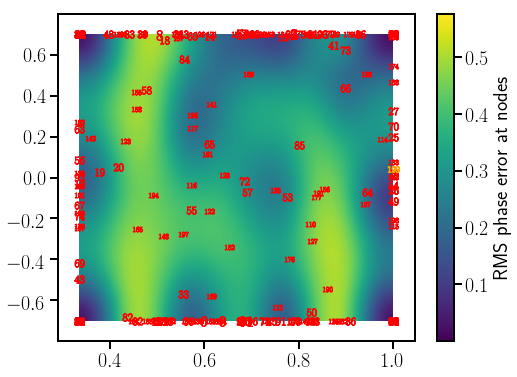

In [89]:
x0, x1, x2, x3, x4 = 1.0, 0.7, -0.7, 10000., 0.
def mismatch_error(x0, x1):
    point = np.array([x0, x1, x2, x3, x4])
    return -sampler.negative_error(point)

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 10
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 10
plot_2d_func(ax1, mismatch_error, xlow, xhigh, nx, ylow, yhigh, ny, 
             colorbar_label=r'RMS phase error at nodes')
plot_numbered_points(ax1, sampler.new_points)

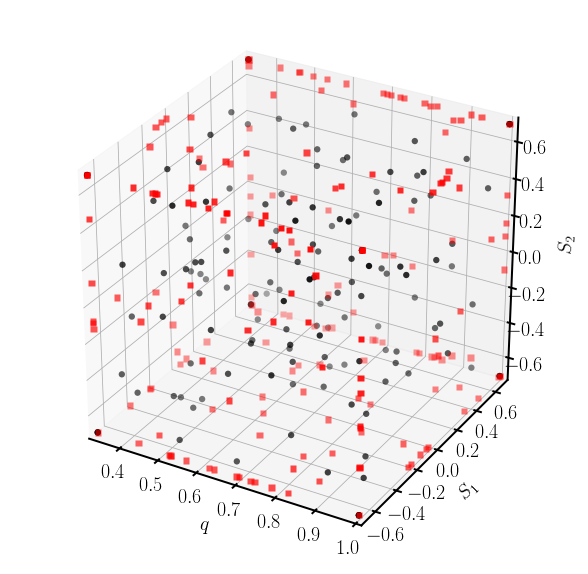

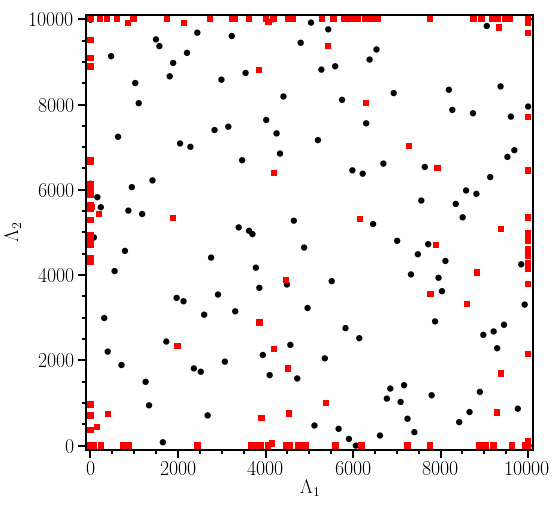

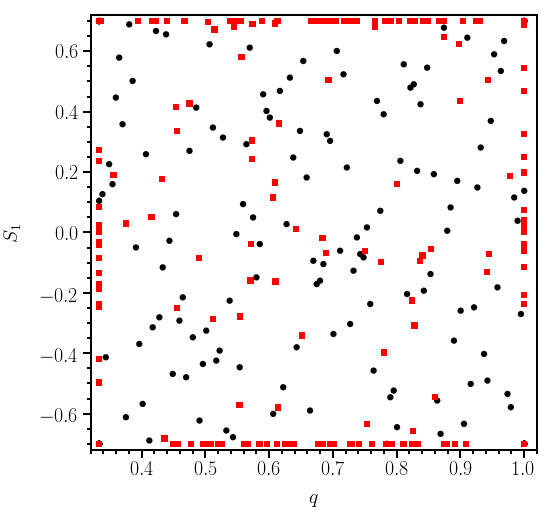

In [99]:
fig = plt.figure(figsize=(10, 10))
axes = fig.add_subplot(111, projection='3d')

x, y, z = original_points[:, 0], original_points[:, 1], original_points[:, 2]
axes.scatter(x, y, z, c='k', edgecolor='none', marker='o', s=40)

x, y, z = sampler.new_points[:, 0], sampler.new_points[:, 1], sampler.new_points[:, 2]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='s', s=40)

axes.set_xlim(0.333, 1.0)
axes.set_ylim(-0.7, 0.7)
axes.set_zlim(-0.7, 0.7)
axes.set_xlabel('$q$', labelpad=10)
axes.set_ylabel('$S_1$', labelpad=15)
axes.set_zlabel('$S_2$', labelpad=18)
#axes.minorticks_on()


fig, axes = plt.subplots(1, figsize=(8, 8))

x, y = original_points[:, 3], original_points[:, 4]
axes.scatter(x, y, c='k', edgecolor='none', marker='o', s=40)

x, y = sampler.new_points[:, 3], sampler.new_points[:, 4]
axes.scatter(x, y, c='r', edgecolor='none', marker='s', s=40)

axes.set_xlim(-100, 10100)
axes.set_ylim(-100, 10100)
axes.set_xlabel('$\Lambda_1$')
axes.set_ylabel('$\Lambda_2$')
axes.minorticks_on()


fig, axes = plt.subplots(1, figsize=(8, 8))

x, y = original_points[:, 0], original_points[:, 1]
axes.scatter(x, y, c='k', edgecolor='none', marker='o', s=40)

x, y = sampler.new_points[:, 0], sampler.new_points[:, 1]
axes.scatter(x, y, c='r', edgecolor='none', marker='s', s=40)

axes.set_xlim(0.32, 1.02)
axes.set_ylim(-0.72, 0.72)
axes.set_xlabel('$q$', labelpad=10)
axes.set_ylabel('$S_1$', labelpad=15)
axes.minorticks_on()

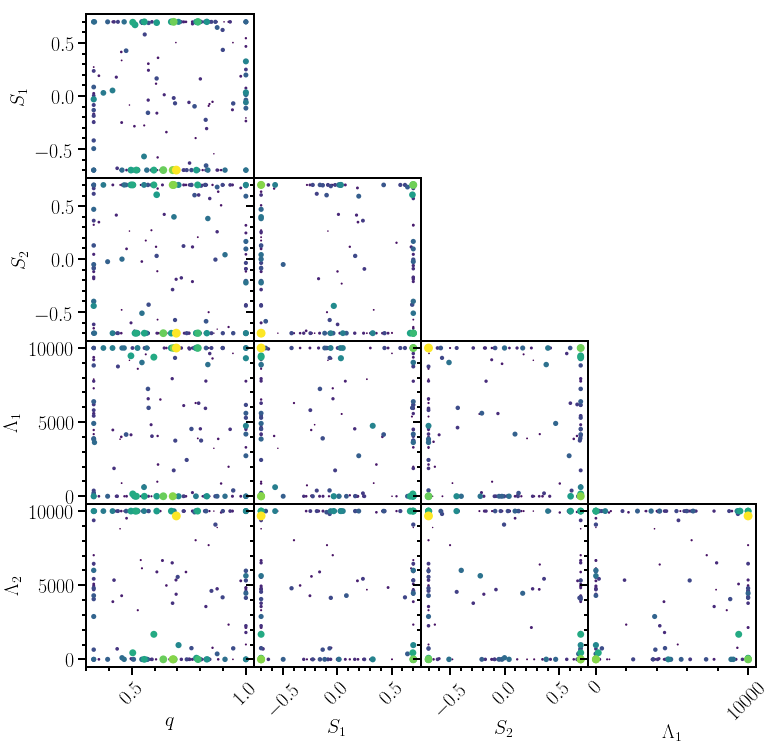

In [91]:
labels = [r'$q$', r'$S_1$', r'$S_2$', r'$\Lambda_1$', r'$\Lambda_2$']
params = sampler.new_points
error = sampler.new_errors
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, figsize=(10, 10))

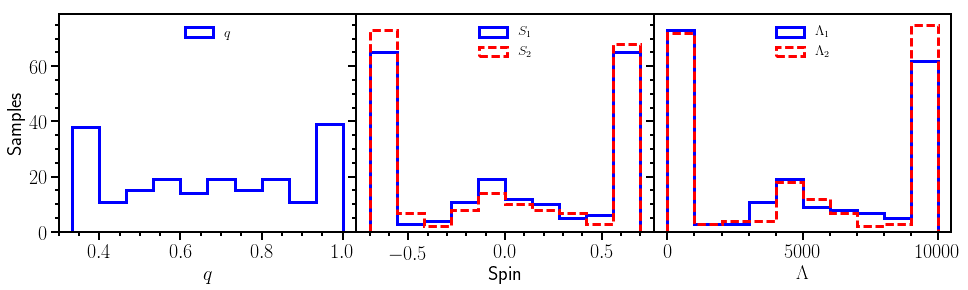

In [93]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16, 4))
fig.subplots_adjust(wspace=0.0)


# Mass ratio
ax1.hist(sampler.new_points[:, 0], bins=10, histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'$q$')
ax1.set_xlabel(labels[0])
ax1.set_ylabel('Samples')
ax1.legend(loc='upper center', frameon=False)
ax1.minorticks_on()


# Spins
ax2.hist(sampler.new_points[:, 1], bins=10, histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'$S_1$')

ax2.hist(sampler.new_points[:, 2], bins=10, histtype='step', 
          ls='--', lw=3, color='red', alpha=1.0, label=r'$S_2$')

ax2.set_xlabel('Spin')
ax2.legend(loc='upper center', frameon=False)
ax2.minorticks_on()


# Tidal parameters
ax3.hist(sampler.new_points[:, 3], bins=10, histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'$\Lambda_1$')

ax3.hist(sampler.new_points[:, 4], bins=10, histtype='step', 
          ls='--', lw=3, color='red', alpha=1.0, label=r'$\Lambda_2$')

ax3.set_xlabel(r'$\Lambda$')
ax3.legend(loc='upper center', frameon=False)
ax3.minorticks_on()